# Content for 03_Modeling Pipeline Setup.ipynb
This notebook loads enriched data from 01_data_collection.ipynb, adds lagged features, prepares data, trains classical models (LR, RF, LogReg, KMeans), and LSTM models.
Saves model results to model_results_dir.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional, Layer
from keras.regularizers import l1_l2
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set paths (same as previous)
ROOT = os.getcwd()
DATA_DIR = os.path.join(ROOT, "data")
ENRICHED_DIR = os.path.join(DATA_DIR, "enriched")
MODEL_RESULTS_DIR = os.path.join(DATA_DIR, 'model_results')
os.makedirs(MODEL_RESULTS_DIR, exist_ok=True)

# Commodity names
commodities = ["Gold", "WTI", "Wheat", "NaturalGas", "Copper", "Lithium"]

# Load enriched data
merged_data = {}
for name in commodities:
    fname = f"{name.lower()}_enriched.csv"
    path = os.path.join(ENRICHED_DIR, fname)
    if os.path.exists(path):
        df = pd.read_csv(path)
        df['Date'] = pd.to_datetime(df['Date'])
        merged_data[name] = df
    else:
        print(f"Missing enriched file for {name}")

In [3]:
# Functions for modeling
def prepare_features_targets(df, features, target):
    X = df[features]
    y = df[target]
    return X, y

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def create_sequences(data, feature_cols, target_col, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[feature_cols].iloc[i:i+seq_length].values
        y = data[target_col].iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def add_lagged_features(df, feature_cols, max_lag=5):
    for col in feature_cols:
        for lag in range(1, max_lag + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

# Modeling - Cell 1: Data Prep, Classical Models, Classification, Clustering

In [4]:
target_return = 'Return'
target_ma = 'MA_5'
lag_features = ['GPRD', 'geo_keyword_hits']

results = {}
train_dfs = {}  # To store for LSTM in next cell
test_dfs = {}   # To store for LSTM in next cell
features_enhanced_dict = {}  # To store for LSTM

for commodity, df in merged_data.items():
    print(f"Processing commodity: {commodity}")

    df['geo_keyword_hits'].fillna(0, inplace=True)
    df['sentiment'].fillna(0, inplace=True)
    if 'EVENT' in df.columns:
        df['EVENT'].fillna('None', inplace=True)

    # Add lagged features
    df = add_lagged_features(df, lag_features, max_lag=5)
    df.dropna(inplace=True)
    print(f"{commodity} - {len(df)} rows after lagged features added and NaN drops.")

    features_baseline = ['Return_lag1']
    features_enhanced = ['Return_lag1', 'GPRD', 'geo_keyword_hits', 'sentiment'] + \
                        [f'{feat}_lag{lag}' for feat in lag_features for lag in range(1, 6)]

    # Convert to numeric and drop any remaining NaNs in features
    df[features_enhanced] = df[features_enhanced].apply(pd.to_numeric, errors='coerce')
    df.dropna(subset=features_enhanced + [target_return], inplace=True)

    # Train/test split (adjusted for reasonable data distribution)
    split_date = pd.to_datetime('2018-01-01')
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    print(f"{commodity} - Train size: {len(train_df)}, Test size: {len(test_df)}")
    if len(train_df) < 20 or len(test_df) < 20:
        print(f"Insufficient samples for {commodity}, skipping.")
        continue

    # Classical models for Return
    X_train_base, y_train = prepare_features_targets(train_df, features_baseline, target_return)
    X_test_base, y_test = prepare_features_targets(test_df, features_baseline, target_return)
    X_train_enh = train_df[features_enhanced]
    X_test_enh = test_df[features_enhanced]

    scaler = StandardScaler()
    X_train_enh_scaled = scaler.fit_transform(X_train_enh)
    X_test_enh_scaled = scaler.transform(X_test_enh)

    # Baseline LR
    lr_base = LinearRegression()
    lr_base.fit(X_train_base, y_train)
    y_pred_base = lr_base.predict(X_test_base)
    rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))

    # Enhanced RF
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_enh_scaled, y_train)
    y_pred_rf = rf.predict(X_test_enh_scaled)
    rmse_enh = np.sqrt(mean_squared_error(y_test, y_pred_rf))

    results[commodity] = {'RMSE_baseline': rmse_base, 'RMSE_enhanced': rmse_enh}

    # Binary classification target
    train_df['Return_binary'] = (train_df['Return'] > 0).astype(int)
    test_df['Return_binary'] = (test_df['Return'] > 0).astype(int)

    # Drop rows with NaNs in classification features
    train_df = train_df.dropna(subset=features_enhanced)
    test_df = test_df.dropna(subset=features_enhanced)

    X_train_class = scaler.fit_transform(train_df[features_enhanced])
    X_test_class = scaler.transform(test_df[features_enhanced])
    y_train_class = train_df['Return_binary']
    y_test_class = test_df['Return_binary']

    # Logistic Regression classifier
    logreg = LogisticRegression(max_iter=200)
    logreg.fit(X_train_class, y_train_class)
    y_pred_class = logreg.predict(X_test_class)
    print(f"{commodity} - Classification Accuracy: {accuracy_score(y_test_class, y_pred_class):.4f}")

    # Clustering for regimes
    kmeans = KMeans(n_clusters=2, random_state=42)
    regime_features = df[['Vol_5', 'GPRD', 'geo_keyword_hits']].fillna(0)
    df['Regime'] = kmeans.fit_predict(regime_features)

    # Store for LSTM in next cell
    train_dfs[commodity] = train_df
    test_dfs[commodity] = test_df
    features_enhanced_dict[commodity] = features_enhanced

    print(f"Finished classical processing for {commodity}\n")

# Save classical results (move to end if you want)
results_df = pd.DataFrame(results).T
results_df.to_csv(os.path.join(MODEL_RESULTS_DIR, 'classical_model_results.csv'))

Processing commodity: Gold
Gold - 5337 rows after lagged features added and NaN drops.
Gold - Train size: 4330, Test size: 1007
Gold - Classification Accuracy: 0.5065
Finished classical processing for Gold

Processing commodity: WTI
WTI - 5346 rows after lagged features added and NaN drops.
WTI - Train size: 4338, Test size: 1008
WTI - Classification Accuracy: 0.5208
Finished classical processing for WTI

Processing commodity: Wheat
Wheat - 5362 rows after lagged features added and NaN drops.
Wheat - Train size: 4354, Test size: 1008
Wheat - Classification Accuracy: 0.5099
Finished classical processing for Wheat

Processing commodity: NaturalGas
NaturalGas - 3689 rows after lagged features added and NaN drops.
NaturalGas - Train size: 2681, Test size: 1008
NaturalGas - Classification Accuracy: 0.5050
Finished classical processing for NaturalGas

Processing commodity: Copper
Copper - 5341 rows after lagged features added and NaN drops.
Copper - Train size: 4334, Test size: 1007
Copper -

# Plot comparison RMSE for baseline LR and enhanced RF

<Figure size 1000x600 with 0 Axes>

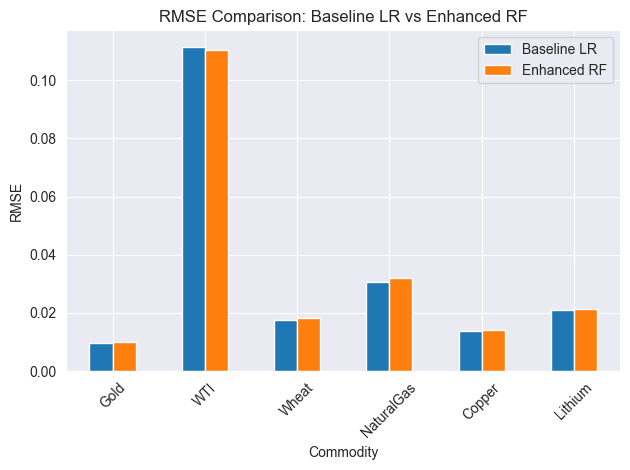

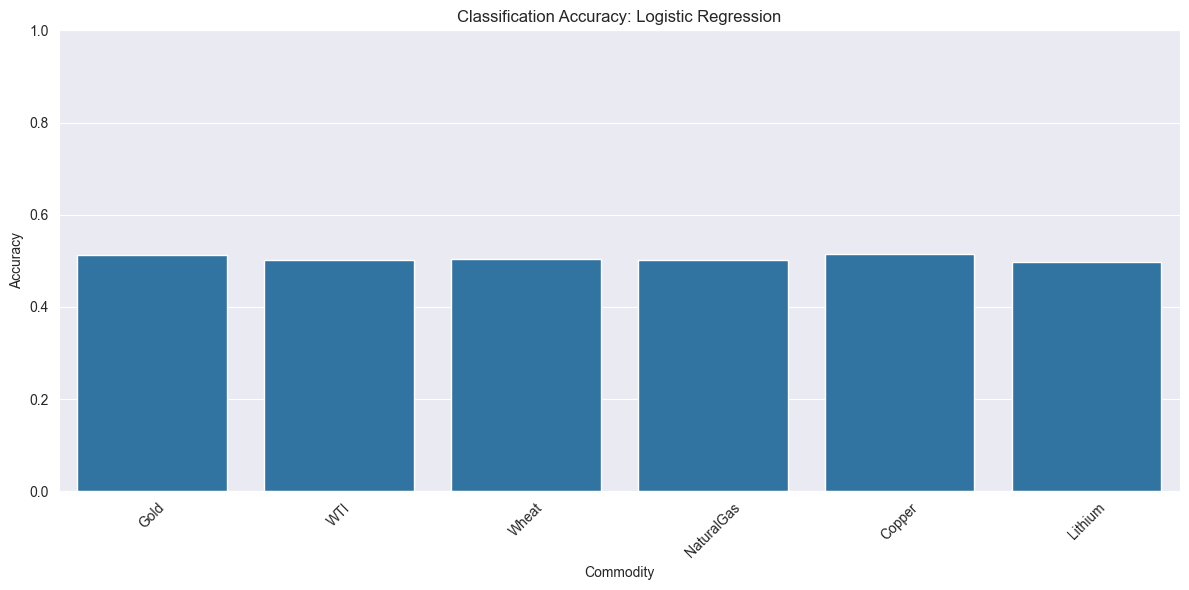

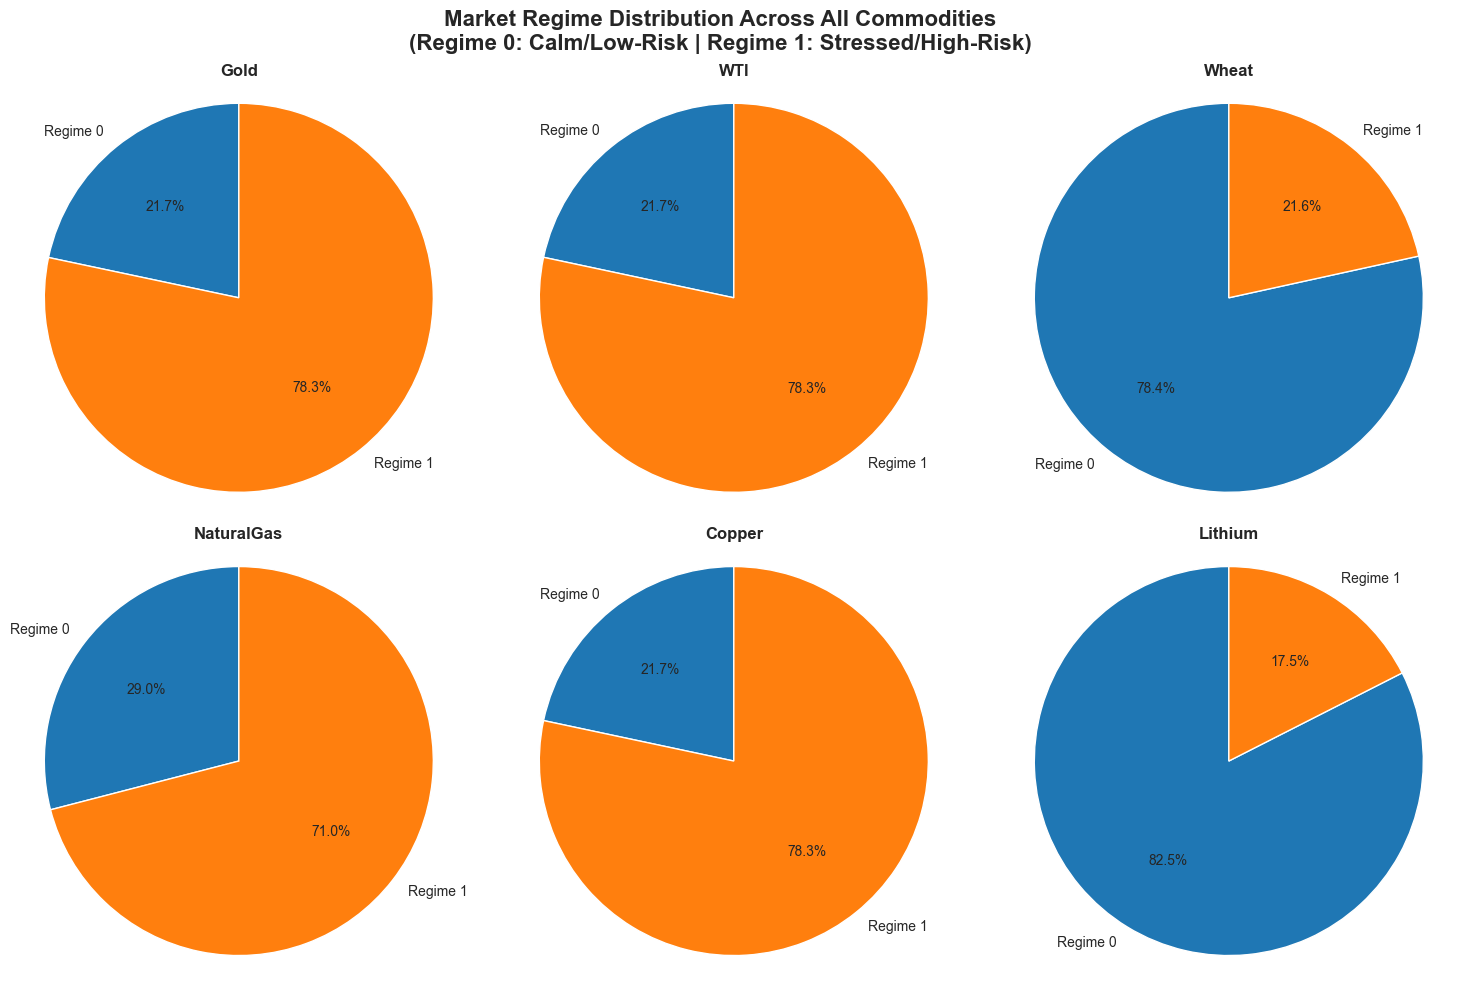

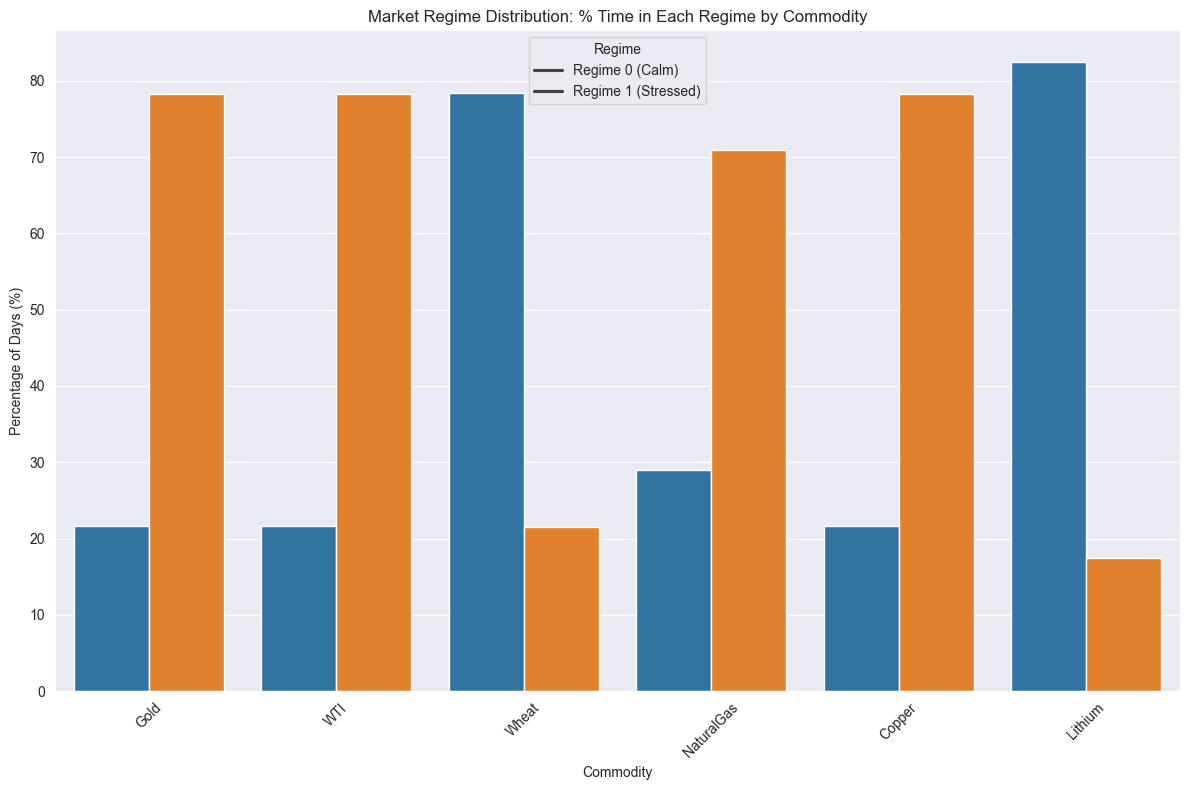

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load results if running this section separately
results_path = os.path.join(MODEL_RESULTS_DIR, 'classical_model_results.csv')
results_df = pd.read_csv(results_path, index_col=0)

# --- Visualize RMSE for Regression Models ---
plt.figure(figsize=(10,6))
results_df[['RMSE_baseline','RMSE_enhanced']].plot.bar(rot=45)
plt.title('RMSE Comparison: Baseline LR vs Enhanced RF')
plt.ylabel('RMSE')
plt.xlabel('Commodity')
plt.tight_layout()
plt.legend(['Baseline LR', 'Enhanced RF'])
plt.savefig(os.path.join(MODEL_RESULTS_DIR, 'rmse_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- (Optional) Bar Plot: Classification Accuracy for Each Commodity ---
accs = {}
for commodity in results_df.index:
    if commodity not in test_dfs:
        continue
    test_df = test_dfs[commodity]
    scaler = StandardScaler()
    X_test_class = scaler.fit_transform(test_df[features_enhanced_dict[commodity]])
    y_test_class = test_df['Return_binary']
    logreg = LogisticRegression(max_iter=200)
    X_train_class = scaler.fit_transform(train_dfs[commodity][features_enhanced_dict[commodity]])
    y_train_class = train_dfs[commodity]['Return_binary']
    logreg.fit(X_train_class, y_train_class)
    y_pred_class = logreg.predict(X_test_class)
    acc = accuracy_score(y_test_class, y_pred_class)
    accs[commodity] = acc

if accs:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(accs.keys()), y=list(accs.values()))
    plt.title("Classification Accuracy: Logistic Regression")
    plt.ylabel("Accuracy")
    plt.xlabel("Commodity")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_RESULTS_DIR, 'classification_accuracy.png'), dpi=300, bbox_inches='tight')
    plt.show()

# --- Visualize Clustering Regimes Distribution - SINGLE IMAGE FOR ALL COMMODITIES ---
regime_data = []
for commodity, df in merged_data.items():
    if 'Regime' not in df.columns:
        continue
    regime_counts = df['Regime'].value_counts().sort_index()
    for regime in regime_counts.index:
        regime_data.append({
            'Commodity': commodity,
            'Regime': f"Regime {regime}",
            'Percentage': regime_counts[regime] / len(df) * 100
        })

regime_df = pd.DataFrame(regime_data)

# Create subplots: 2 rows, 3 columns = 6 commodities
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, commodity in enumerate(commodities):
    if i >= len(axes):
        break
    ax = axes[i]

    # Filter data for this commodity
    commo_data = regime_df[regime_df['Commodity'] == commodity]

    if not commo_data.empty:
        colors = ['#1f77b4', '#ff7f0e']  # Blue for Regime 0, Orange for Regime 1
        wedges, texts, autotexts = ax.pie(commo_data['Percentage'],
                                        labels=commo_data['Regime'],
                                        autopct='%1.1f%%',
                                        colors=colors[:len(commo_data)],
                                        startangle=90)
        ax.set_title(f"{commodity}", fontsize=12, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No Regime Data', ha='center', va='center')
        ax.set_title(f"{commodity}", fontsize=12)

    ax.axis('equal')

plt.suptitle('Market Regime Distribution Across All Commodities\n(Regime 0: Calm/Low-Risk | Regime 1: Stressed/High-Risk)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_RESULTS_DIR, 'all_commodities_regime_pie.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- Optional: Stacked Bar Alternative (shows % comparison clearly) ---
plt.figure(figsize=(12, 8))
sns.barplot(data=regime_df, x='Commodity', y='Percentage', hue='Regime', palette=['#1f77b4', '#ff7f0e'])
plt.title('Market Regime Distribution: % Time in Each Regime by Commodity')
plt.ylabel('Percentage of Days (%)')
plt.xlabel('Commodity')
plt.legend(title='Regime', labels=['Regime 0 (Calm)', 'Regime 1 (Stressed)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_RESULTS_DIR, 'regime_stacked_bar.png'), dpi=300, bbox_inches='tight')
plt.show()


# best outcome R²>0,2


Processing refined LSTM for Gold
Features: ['Return_lag1', 'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5'], Len: 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 - 11s - 412ms/step - loss: 0.1004 - val_loss: 0.0886
Epoch 2/50
27/27 - 2s - 73ms/step - loss: 0.0811 - val_loss: 0.0729
Epoch 3/50
27/27 - 2s - 80ms/step - loss: 0.0669 - val_loss: 0.0602
Epoch 4/50
27/27 - 2s - 87ms/step - loss: 0.0552 - val_loss: 0.0496
Epoch 5/50
27/27 - 1s - 49ms/step - loss: 0.0455 - val_loss: 0.0409
Epoch 6/50
27/27 - 1s - 52ms/step - loss: 0.0375 - val_loss: 0.0338
Epoch 7/50
27/27 - 1s - 42ms/step - loss: 0.0310 - val_loss: 0.0279
Epoch 8/50
27/27 - 1s - 38ms/step - loss: 0.0257 - val_loss: 0.0232
Epoch 9/50
27/27 - 1s - 40ms/step - loss: 0.0214 - val_loss: 0.0193
Epoch 10/50
27/27 - 1s - 40ms/step - loss: 0.0179 - val_loss: 0.0162
Epoch 11/50
27/27 - 1s - 35ms/step - loss: 0.0150 - val_loss: 0.0137
Epoch 12/50
27/27 - 1s - 35ms/step - loss: 0.0127 - val_loss: 0.0116
Epoch 13/50
27/27 - 1s - 35ms/step - loss: 0.0108 - val_loss: 0.0099
Epoch 14/50
27/27 - 1s - 37ms/step - loss: 0.0093 - val_loss: 0.0085
Epoch 15/50
27/27 - 1s - 44ms/step - loss

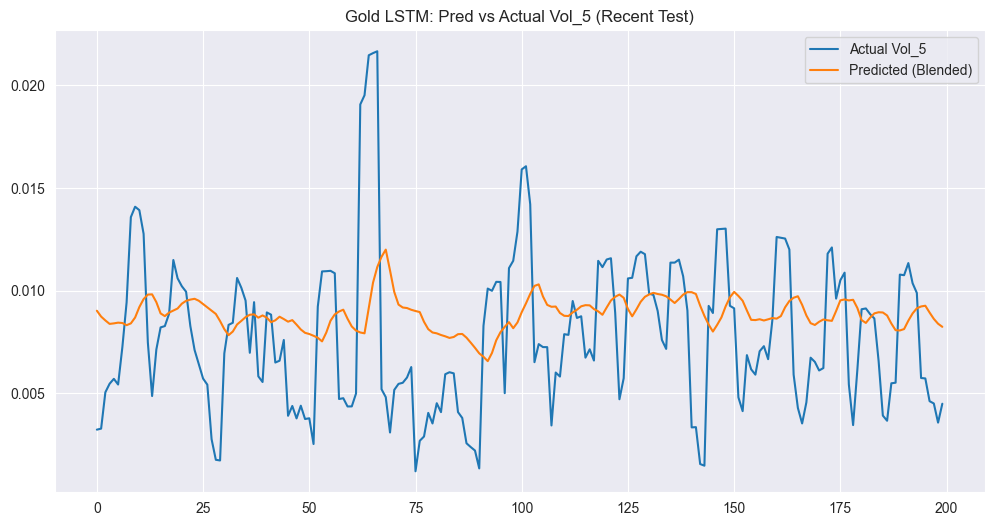

np.float64(1.0)

In [4]:
# Modeling - Cell 2: Refined LSTM for Vol_5 (Vol Target, Clip Preds)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

results_lstm = {}

for commodity in train_dfs.keys():
    if commodity != 'Gold': continue

    print(f"Processing refined LSTM for {commodity}")

    df = merged_data[commodity].copy()
    df = add_lagged_features(df, ['Vol_5', 'Return'], max_lag=5)
    df.dropna(inplace=True)

    features_enhanced = [f'Return_lag{lag}' for lag in range(1, 6)] + \
                        [f'Vol_5_lag{lag}' for lag in range(1, 6)]

    print(f"Features: {features_enhanced}, Len: {len(features_enhanced)}")

    split_date = pd.to_datetime('2018-01-01')
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    target = 'Vol_5'  # Switch to vol for geo alignment
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    seq_length = 20
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) < 5 or len(X_test_seq) < 5:
        print(f"Skipping {commodity} due to few sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.0005), loss='mean_squared_error')
    model.summary()

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq).squeeze()

    # Blend and clip preds (reduce extremes)
    mean_pred = np.full_like(y_pred_lstm, np.mean(y_train))
    y_pred_blend = 0.7 * y_pred_lstm + 0.3 * mean_pred
    y_pred_blend = np.clip(y_pred_blend, np.min(y_test_seq) * 0.9, np.max(y_test_seq) * 1.1)  # Clip to test range

    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_blend))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_blend)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_blend) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_blend)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_seq[-200:], label='Actual Vol_5')
    plt.plot(y_pred_blend[-200:], label='Predicted (Blended)')
    plt.title('Gold LSTM: Pred vs Actual Vol_5 (Recent Test)')
    plt.legend()
    plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'refined_lstm_gold_vol.csv'))
np.mean(np.sign(y_pred_blend) == np.sign(y_test_seq))

# run for every commodity

In [6]:
# Modeling - Cell 2: Refined LSTM for Vol_5 (Vol Target, Clip Preds)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

results_lstm = {}

for commodity in train_dfs.keys():


    print(f"Processing refined LSTM for {commodity}")

    df = merged_data[commodity].copy()
    df = add_lagged_features(df, ['Vol_5', 'Return'], max_lag=5)
    df.dropna(inplace=True)

 # Include ALL relevant features in LSTM
features_enhanced = [
    # Price dynamics
    f'Return_lag{lag}' for lag in range(1, 6)
] + [
    # Volatility regime
    f'Vol_5_lag{lag}' for lag in range(1, 6)
] + [
    # Geopolitical risk
    f'GPRD_lag{lag}' for lag in range(1, 6)
] + [
    # News signals
    f'geo_keyword_hits_lag{lag}' for lag in range(1, 6)
] + [
    # Market microstructure
    'sentiment', 'MA_5', 'MA_20'
]

    print(f"Features: {features_enhanced}, Len: {len(features_enhanced)}")

    split_date = pd.to_datetime('2018-01-01')
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    target = 'Vol_5'  # Switch to vol for geo alignment
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    seq_length = 20
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) < 5 or len(X_test_seq) < 5:
        print(f"Skipping {commodity} due to few sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.0005), loss='mean_squared_error')
    model.summary()

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq).squeeze()

    # Blend and clip preds (reduce extremes)
    mean_pred = np.full_like(y_pred_lstm, np.mean(y_train))
    y_pred_blend = 0.7 * y_pred_lstm + 0.3 * mean_pred
    y_pred_blend = np.clip(y_pred_blend, np.min(y_test_seq) * 0.9, np.max(y_test_seq) * 1.1)  # Clip to test range

    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_blend))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_blend)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_blend) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_blend)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_seq[-200:], label='Actual Vol_5')
    plt.plot(y_pred_blend[-200:], label='Predicted (Blended)')
    plt.title('Gold LSTM: Pred vs Actual Vol_5 (Recent Test)')
    plt.legend()
    plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'refined_lstm_gold_vol.csv'))
np.mean(np.sign(y_pred_blend) == np.sign(y_test_seq))

IndentationError: unexpected indent (1303443568.py, line 45)